# Imports

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1

2023-06-09 22:14:11.934985: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Get Data

Data is from kaggle https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities

Data folder in this directory looks like this : 20 files with name city-weekends(or weekdays).csv
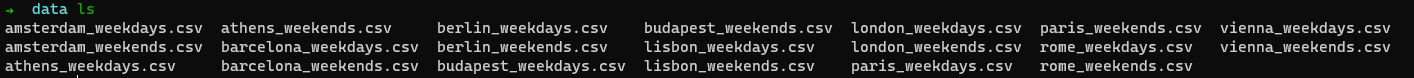

Make a concatenated dataframe with a new column 'filename'

In [2]:
globbed_files = glob.glob("data/*.csv")
data=[]
for csv in globbed_files:
    frame = pd.read_csv(csv)
    frame['filename'] = os.path.basename(csv)
    data.append(frame)

In [3]:
df = pd.concat(data)

Make new columns 'weekday_weekend' & 'city', as they are the information we need from the filenames

In [4]:
df['weekday_weekend'] = df['filename'].map(lambda x: x.split('_')[1].rstrip('.csv'))
df['city'] = df['filename'].map(lambda x: x.split('_')[0])

In [5]:
#removing unnecessary columns for this analysis
df = df.drop(columns=['multi','biz','filename', 'Unnamed: 0', 'attr_index','attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat'])

In [6]:
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,weekday_weekend,city
0,332.048691,Entire home/apt,False,False,6.0,True,10.0,99.0,1,0.359372,0.352662,weekend,budapest
1,331.108709,Entire home/apt,False,False,6.0,False,9.0,98.0,2,0.929438,0.200219,weekend,budapest
2,243.925365,Entire home/apt,False,False,6.0,False,10.0,95.0,2,0.674318,0.314709,weekend,budapest
3,206.561075,Entire home/apt,False,False,5.0,True,10.0,99.0,2,1.338114,0.614128,weekend,budapest
4,238.285473,Entire home/apt,False,False,4.0,False,9.0,84.0,0,0.835635,0.175568,weekend,budapest


'realSum' is 'the total price of the Airbnb listing' and the target. 

In [7]:
X = df.drop(columns='realSum')
y = df.realSum

In [8]:
np.average(y)

279.8795910937968

See the correlation matrix...

<AxesSubplot:>

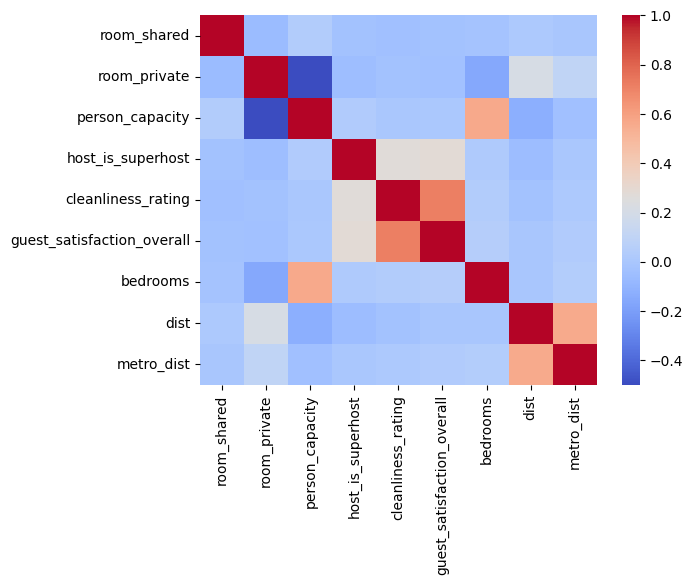

In [9]:
sns.heatmap(X.corr(), cmap='coolwarm')

room_private(boolean) and person_capacity seem relatively highly correlated. --> drop room_private

In [10]:
X = df.drop(columns=['realSum', 
                        'room_private'])

In [11]:
X_num_col = X.select_dtypes(include=['float', 'int']).columns
X_str_col = X.select_dtypes(include=['object', 'bool']).columns

## Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41365, 11), (10342, 11), (41365,), (10342,))

## Preprocess numerical / categorical columns

In [13]:
num_transformer = StandardScaler()

cat_transformer = OneHotEncoder(handle_unknown='ignore', drop='if_binary')

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, X_num_col),
    ('cat_transformer', cat_transformer, X_str_col)
])

preprocessor

ColumnTransformer(transformers=[('num_transformer', StandardScaler(),
                                 Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist'],
      dtype='object')),
                                ('cat_transformer',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 Index(['room_type', 'room_shared', 'host_is_superhost', 'weekday_weekend',
       'city'],
      dtype='object'))])

In [14]:
X_train_transformed = preprocessor.fit_transform(X_train)

print("X_train")
display(X_train.head())
print(X_train.shape)

print("X_train_processed")
display(pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out()
).head())
print(X_train_transformed.shape)

X_train


,room_type,room_shared,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,weekday_weekend,city
1396,Entire home/apt,False,5.0,False,10.0,96.0,2,1.657024,0.984947,weekend,athens
2189,Private room,False,3.0,False,10.0,95.0,1,3.406355,1.103844,weekday,rome
1591,Private room,False,2.0,False,9.0,95.0,1,6.351677,0.932549,weekend,london
2562,Private room,False,2.0,True,10.0,99.0,1,1.103531,0.230068,weekday,lisbon
54,Entire home/apt,False,4.0,False,10.0,98.0,2,4.101559,3.132286,weekday,lisbon


(41365, 11)
X_train_processed


,num_transformer__person_capacity,num_transformer__cleanliness_rating,num_transformer__guest_satisfaction_overall,num_transformer__bedrooms,num_transformer__dist,num_transformer__metro_dist,cat_transformer__room_type_Entire home/apt,cat_transformer__room_type_Private room,cat_transformer__room_type_Shared room,cat_transformer__room_shared_True,...,cat_transformer__city_amsterdam,cat_transformer__city_athens,cat_transformer__city_barcelona,cat_transformer__city_berlin,cat_transformer__city_budapest,cat_transformer__city_lisbon,cat_transformer__city_london,cat_transformer__city_paris,cat_transformer__city_rome,cat_transformer__city_vienna
0,1.409817,0.638379,0.376133,1.332317,-0.641034,0.349907,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.127756,0.638379,0.264709,-0.255219,0.089385,0.487444,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.896543,-0.411208,0.264709,-0.255219,1.319181,0.289295,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.896543,0.638379,0.710403,-0.255219,-0.872140,-0.523314,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.641030,0.638379,0.598980,1.332317,0.379662,2.833883,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


(41365, 22)


# Neural Network

In [15]:
model = models.Sequential()
    
model.add(layers.Dense(20, activation='relu', input_dim = X_train_transformed.shape[-1]))

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu',  kernel_regularizer = L1(0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam',
              loss='msle')

In [16]:
es = EarlyStopping(patience=10, restore_best_weights=True)
epochs = 20
batch_size = 16

history = model.fit(X_train_transformed, 
                    y_train,
                    validation_split=0.3,
                    epochs = epochs,         
                    batch_size = batch_size,
                    callbacks=[es],
                    verbose = 1)

Epoch 1/20
1810/1810 [==============================] - 7s 3ms/step - loss: 6.2321 - val_loss: 1.0327
Epoch 2/20
1810/1810 [==============================] - 6s 3ms/step - loss: 1.8323 - val_loss: 0.4766
Epoch 3/20
1810/1810 [==============================] - 6s 3ms/step - loss: 1.3493 - val_loss: 0.3584
Epoch 4/20
1810/1810 [==============================] - 6s 3ms/step - loss: 1.1142 - val_loss: 0.2663
Epoch 5/20
1810/1810 [==============================] - 6s 3ms/step - loss: 1.0411 - val_loss: 0.2437
Epoch 6/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.9573 - val_loss: 0.2065
Epoch 7/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.6775 - val_loss: 0.2572
Epoch 8/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.5544 - val_loss: 0.2378
Epoch 9/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.4727 - val_loss: 0.2050
Epoch 10/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.427

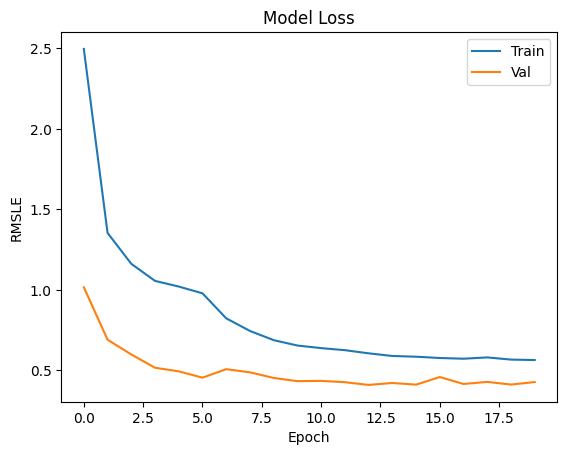

In [17]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
plot_history(history)

In [18]:
X_test_transformed = preprocessor.transform(X_test)

In [19]:
res = model.evaluate(X_test_transformed, y_test)**0.5
print(f'RMSLE evaluated on test set is {round(res, 2)}')

324/324 [==============================] - 1s 2ms/step - loss: 0.1818
RMSLE evaluated on test set is 0.43


# How much would this airbnb cost??

In [20]:
random = np.random.randint(0,len(X_test), 1)

In [21]:
X_test_example = X_test.iloc[random]
X_test_example

,room_type,room_shared,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,weekday_weekend,city
924,Entire home/apt,False,2.0,False,10.0,100.0,0,5.279827,0.25231,weekend,berlin


## Predicted price is...

In [22]:
example_transformed = preprocessor.transform(X_test_example)
model.predict(example_transformed)

1/1 [==============================] - 0s 93ms/step


array([[203.7115]], dtype=float32)

## True price is....

In [23]:
pd.DataFrame(y_test).iloc[random]

,realSum
924,220.155184
